In [2]:
##Valeurs des constantes


# grains
R = 1
m = 1

# exterieur
L=10
e=0
y_min = -5000
g = 3000

# paramètres des contacts
Kc = 5*1e5/(2*R)
restitution = 0.4
Kd = restitution**2*Kc
Kc_p = 1e6/(2*R)
restitution_p = 0.4
Kd_p = restitution_p**2*Kc_p
Kt = 0
mu = 0.7
mu_p = 0.7
Kt_p = 0
alpha_0 = 0
dt = 1e-3

In [6]:
### Condtitions
paroie = True
remove = True

In [7]:
##Cellule des imports 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
import random as rd

# Premiere version de l'algorithme (méthode d'Euler + animation qualitative)

In [ ]:
#Cellule de classes et methodes sur ces classes 


class grain :
    
    def __init__(self,x0,y0,vx0,vy0):
        self.pos = np.array([x0,y0]) #position initiale du centre
        self.vit = np.array([vx0,vy0]) #vitesse initiale nulle
        self.acc = np.array([0,-g],dtype='float64') #accélération
        self.pos_n = np.array([x0,y0]) 
        self.vit_n = np.array([vx0,vy0]) 
        self.norme_forces = 0 
        self.voisins = [] #liste des voisins
        self.bords = [] #liste de booléens [gauche,bas,droite], True si contact, False sinon
        
    def detecter_voisins(self):
        # on teste tous les grains (différents de i) pour voir si ils sont en contact
        self.voisins=[]
        for k in grains:
            if ((k.pos[0]-self.pos[0])**2+(k.pos[1]-self.pos[1])**2 < 4*R**2) and k != self:
                self.voisins.append(k)
                
                
    def contact_paroi(self):
        self.bords = []
        if self.pos[0] < -L/2 + R:
          self.bords.append(True)
        else:
           self.bords.append(False)
        if self.pos[1] < R: #and (self.pos[0] < -e or self.pos[0] > e):
           self.bords.append(True)
        else:
           self.bords.append(False)
        if self.pos[0] > L/2 - R:
           self.bords.append(True)
        else:
           self.bords.append(False)


In [ ]:
##Cellules des fonctions utiles 

def perp_vec(a,v):
    x,y = a
    if y != 0:
        b = np.array([1/np.sqrt(1+(x/y)**2),-x/(y*np.sqrt(1+(x/y)**2))])
    else :
        b = np.array([-y/(x*np.sqrt(1+(y/x)**2)),1/(np.sqrt(1+(y/x)**2))])
    if np.dot(b,v) > 0 : return b
    else : return -b
    




def Force_totale(i,j):
    '''A partir de deux grains i et j renvoie FTo = np.array([FTox, FToy])  i-->j'''
    
    xi, yi = i.pos_n
    xj, yj = j.pos_n
    vxi , vyi = i.pos_n  
    vxj , vyj = j.vit_n
    
    rij = np.array([xj -xi , yj-yi])
    vij = np.array([vxj - vxi, vyj - vyi])
    
    nij = rij / np.sqrt(np.dot(rij,rij))
    tij = perp_vec(nij,vij) 
    
    alpha = 2*R - np.sqrt(np.dot(rij,rij)) 
    vit_tan = np.dot(vij,tij)
    
    if np.dot(nij,vij) < 0:
        return  Kc*alpha*nij - min((mu*Kc*alpha, Kt*vit_tan))*tij
    if np.dot(nij,vij) > 0:
        return Kd*(alpha - alpha_0)*nij - min((mu*Kd*alpha, Kt*vit_tan))*tij          


def force_paroi(i):
    x,y = i.pos
    vx,vy = i.vit
    f = np.array([0.,0.])
    if i.bords[0] == True :
        alpha = -(x-R+L/2)
        if vx > 0 :
            f += np.array([Kd_p*alpha,-min((mu_p*Kc_p*alpha, Kt_p*vy))])
        if vx <= 0 :
            f += np.array([Kc_p*alpha,-min((mu_p*Kd_p*alpha, Kt_p*vy))])
    if i.bords[2] == True :
        alpha = x+R-L/2
        if vx > 0 :
            f += np.array([-Kc_p*alpha,-min((mu_p*Kc_p*alpha, Kt_p*vy))])
        if vx <= 0 :
            f += np.array([-Kd_p*alpha,-min((mu_p*Kd_p*alpha, Kt_p*vy))])
    if i.bords[1] == True :
        alpha = R-y
        if vy > 0 :
            f += np.array([-min((mu_p*Kc_p*alpha, Kt_p*vy)), Kd_p*alpha])
        if vy <= 0 :
            f += np.array([-min((mu_p*Kc_p*alpha, Kt_p*vy)), Kc_p*alpha])
    return f
    
    
    
    
    

def force(i):
    force = np.array([0,-m*g],dtype='float64')
    i.detecter_voisins()
    i.contact_paroi()
    for j in i.voisins:
        force += Force_totale(j,i)
    force += force_paroi(i)
    return force
    
  
  
  
  

def mise_a_jour():
    # 1 : calculer les nouvelles vitesses/positions de tous les grains
    # 2 : les "nouvelles positions/vitesses" deviennent les pos/vit actuelles
    #     si un grain sort du silo on ne le prend plus en compte dans l'étude
    for i in grains:
        i.norme_forces = np.sqrt(np.dot(force(i), force(i)))
        i.acc = 1/m * force(i)
        i.vit_n = i.vit + dt * i.acc
        i.pos_n = i.pos + dt * i.vit_n
    for i in grains:
        i.pos = i.pos_n
        i.vit = i.vit_n
        if i.pos[1] < y_min :
            grains.remove(i)




def afficher(grains0):
    global fenetre
    fig, ax = fenetre
    patches = []
    for i in grains0 :
        x = i.pos[0]
        y = i.pos[1]
        circle = pat.Circle((x, y), R)
        patches.append(circle)
    
    p = PatchCollection(patches, alpha=0.5, linestyle = 'solid')
    ax.add_collection(p)
    plt.show()


def update(frame_nb):
    global fenetre
    for artist in plt.gca().lines + plt.gca().collections:
        artist.remove()
    patches = []
    colors = np.zeros((0,0))
    for indice,i in enumerate(grains) :
        x = i.pos[0]
        y = i.pos[1]
        circle = pat.Circle((x, y), R)
        patches.append(circle)
        colors = np.append(colors,i.pos[0])
    mise_a_jour()
    p = PatchCollection(patches, alpha=0.5, linestyle = 'solid', cmap=matplotlib.cm.jet)
    p.set_array(colors)
    ax.add_collection(p)
        


def animer(grains0):
    global fenetre
    #représente l'évolution temporelle et spatiale d'un ensemble initial de grains (grains0)
    grains = grains0
    ani = animation.FuncAnimation(fig, update,  blit=False, interval=1, repeat=True)
    sm = plt.cm.ScalarMappable(cmap="nipy_spectral", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()

In [ ]:
#Cellule de test de la première animation 
somme_vitesse = []
fig = plt.figure(1,figsize=(7,7))
plt.axis("equal")
ax = plt.axes(xlim=(-L/2,L/2), ylim=(0,L))
fenetre = fig, ax
grains = []
       
grains = grains = [grain(0,R+2*R*k,0,0) for k in range(0,20)]
animer(grains)

# Deuxieme version de l'algorithme (Methode de Verlet)

In [11]:
##Cellule de classes + methodes (pour l'instant id a celle de la v1)

class grain :
    '''
    Definition des méthodes et attributs des grains
    '''
    
    def __init__(self,x0,y0,vx0,vy0):
        self.pos = np.array([x0,y0]) #position à t
        self.vit = np.array([vx0,vy0]) #vitesse à t
        self.acc = np.array([0.,0.], dtype = 'float64') #accélération à t
        
        self.pos_a = np.array([x0,y0]) - np.array([vx0,vy0])*dt  # position à t-dt
        self.pos_n = np.array([x0,y0]) #position à t+dt
        self.vit_n = np.array([vx0,vy0]) #position à t+dt
        self.force = np.array([0,0]) #force_totale(i) a t 
        self.force_voisins = np.array([0.,0.])
        self.force_paroi = np.array([0.,0.])
        self.grav = np.array([0.,0.])
        
        self.voisins = [] #liste des voisins
        self.bords = [] #liste de booléens [gauche,bas,droite], True si contact, False sinon
        
    def detecter_voisins(self):
        '''
        Renvoie la liste des grains j en contact avec le grain self
        On teste tous les grains (différents de i) pour voir si ils sont en contact
        '''
        self.voisins=[]
        for k in grains:
            if ((k.pos[0]-self.pos[0])**2+(k.pos[1]-self.pos[1])**2 < 4*R**2) and k != self:
                self.voisins.append(k)
                
                
    def detecter_paroi(self):
        self.bords = []
        if self.pos[0] < -L/2 + R:
          self.bords.append(True)
        else:
           self.bords.append(False)
        if self.pos[1] < R and (self.pos[0] < -e or self.pos[0] > e):
           self.bords.append(True)
        else:
           self.bords.append(False)
        if self.pos[0] > L/2 - R:
           self.bords.append(True)
        else:
            self.bords.append(False)

In [14]:
##Cellules des fonctions 

def perp_vec(a,v):
    x,y = a
    if y != 0:
        b = np.array([1/np.sqrt(1+(x/y)**2),-x/(y*np.sqrt(1+(x/y)**2))])
    else :
        b = np.array([-y/(x*np.sqrt(1+(y/x)**2)),1/(np.sqrt(1+(y/x)**2))])
    if np.dot(b,v) > 0 : return b
    else : return -b
    




def force_grain(i,j):
    '''
    Fonction de calcul de la force due au grain i s'appliquant sur le grain j
    '''
    xi, yi = i.pos
    xj, yj = j.pos
    vxi, vyi = i.pos
    vxj, vyj = j.vit
    
    rij = np.array([xj -xi , yj-yi])
    vij = np.array([vxj - vxi, vyj - vyi])
    
    nij = rij / np.sqrt(np.dot(rij,rij))
    tij = perp_vec(nij,vij) 
    
    delta = 2*R - np.sqrt(np.dot(rij,rij)) 
    vit_tan = np.dot(vij,tij)
    
    if np.dot(nij,vij) < 0:
        return Kc*delta*nij - min((mu*Kc*delta, Kt*vit_tan))*tij
    if np.dot(nij,vij) > 0:
        return Kd*delta*nij - min((mu*Kd*delta, Kt*vit_tan))*tij 



def force_paroi(i, nouveau = True):
    if nouveau == True :
        x,y = i.pos_n
        vx,vy = i.vit_n
    if nouveau == False :
        x,y = i.pos
        vx,vy = i.vit
    f = np.array([0.,0.])
    if i.bords[0] == True :
        alpha = -(x-R+L/2)
        if vx > 0 :
            f += np.array([Kd_p*alpha,-min((mu_p*Kc_p*alpha, Kt_p*vy))])
        if vx <= 0 :
            f += np.array([Kc_p*alpha,-min((mu_p*Kd_p*alpha, Kt_p*vy))])
    if i.bords[2] == True :
        alpha = x+R-L/2
        if vx > 0 :
            f += np.array([-Kc_p*alpha,-min((mu_p*Kc_p*alpha, Kt_p*vy))])
        if vx <= 0 :
            f += np.array([-Kd_p*alpha,-min((mu_p*Kd_p*alpha, Kt_p*vy))])
    if i.bords[1] == True :
        alpha = R-y
        if vy > 0 :
            f += np.array([-min((mu_p*Kc_p*alpha, Kt_p*vx)), Kd_p*alpha])
        if vy <= 0 :
            f += np.array([-min((mu_p*Kc_p*alpha, Kt_p*vx)), Kc_p*alpha])
    return f
    
    
    
    
    


def force_totale(i):
    '''
    Fonction renvoyant la force totale s'appliquant sur le grain i.
    gravite : détermine si le poids est pris en compte dans la force
    paroi : détermine si la force du récipient est prise en compte
    '''
    force = np.array([0.,0.],dtype='float64')
    i.detecter_voisins()
    i.detecter_paroi()
    i.force_voisins = np.array([0.,0.])
    i.force_paroi = np.array([0.,0.])
    i.grav = np.array([0.,0.])
    for j in i.voisins:
        fg = force_grain(j,i) 
        force += fg
        i.force_voisins += fg 
        
    if paroi == True :
        fp = force_paroi(i)  
        force += fp 
        i.force_paroi += fp
    if gravite == True :
        fgrav = np.array([0.,-m*g],dtype='float64')
        force += fgrav
    return force
  
  

def mise_a_jour(remove=True):
    '''
    Fonction de mise à jour de la liste des positions/vitesses des grains par l'algorithme de Verlet à deux pas.
    1 : calculer les nouvelles vitesses/positions de tous les grains
    2 : les "nouvelles positions/vitesses" deviennent les pos/vit actuelles
        lorsque remove vaut True : si un grain sort du silo (y < y_min) on ne le prend plus en compte dans l'étude
    '''
    for i in grains:
        f = force_totale(i)
        i.force = f 
        i.pos_n = 2 * i.pos - i.pos_a + 1/m * f * dt**2
        i.vit_n = (i.pos_n - i.pos_a)/(2*dt)
    for i in grains:
        i.pos, i.pos_a = i.pos_n, i.pos
        i.vit = i.vit_n
        if i.pos[1] < y_min :
            if remove == True:
                grains.remove(i)



def afficher(grains0):
    global fenetre
    fig, ax = fenetre
    patches = []
    for i in grains0 :
        x = i.pos[0]
        y = i.pos[1]
        circle = pat.Circle((x, y), R)
        patches.append(circle)
    p = PatchCollection(patches, alpha=0.5, linestyle = 'solid', color = 'k')
    ax.add_collection(p)
    plt.show()


def update(frame_nb):
    global fenetre
    for artist in plt.gca().lines + plt.gca().collections:
        artist.remove()
    patches = []
    for i in grains :
        x = i.pos[0]
        y = i.pos[1]
        circle = pat.Circle((x, y), R)
        patches.append(circle)
    p = PatchCollection(patches, alpha=0.5, linestyle = 'solid', color = 'r')
    ax.add_collection(p)
    plt.title('t = {:2f}'.format(frame_nb*dt)) 
    mise_a_jour()
    



def animer(grains0, film = False):
    global fenetre
    #représente l'évolution temporelle et spatiale d'un ensemble initial de grains (grains0)
    grains = grains0
    ani = animation.FuncAnimation(fig, update,  blit=False, interval=1, repeat=True)
    return ani
  

def trajectoires(grains, t_final):
    '''
    Renvoie les trajectoires [X,Y,VX,VY,temps] qui sont tous des arrays d'un ensemble de grains initial 'grains', entre les instants 0 et t_final
    '''
    t = 0
    X = [[] for k in range(len(grains))]
    Y = [[] for k in range(len(grains))]
    VX = [[] for k in range(len(grains))]
    VY = [[] for k in range(len(grains))]
    FX = [[] for k in range(len(grains))] #forces totales en x sur les grains
    FY = [[] for k in range(len(grains))]  
    FpX = [[] for k in range(len(grains))]#forces de la paroi en y sur les grains 
    FpY = [[] for k in range(len(grains))]
    FvX = [[] for k in range(len(grains))]#forces des voisisns en x sur les grains
    FvY = [[] for k in range(len(grains))]
    G = [[] for k in range(len(grains))]
    
    temps = []
    while t < t_final:
        temps.append(t)
        for i in range(len(grains)) :
            X[i].append(grains[i].pos[0])
            Y[i].append(grains[i].pos[1])
            VX[i].append(grains[i].vit[0])
            VY[i].append(grains[i].vit[1])
            FX[i].append(grains[i].force[0])
            FY[i].append(grains[i].force[1])
            FpX[i].append(grains[i].force_paroi[0])
            FpY[i].append(grains[i].force_paroi[1])
            FvX[i].append(grains[i].force_voisins[0])
            FvY[i].append(grains[i].force_voisins[1])
            G[i].append(grains[i].grav[1])


        mise_a_jour()
        t += dt
    return(np.array(temps),np.array(X),np.array(Y),np.array(VX),np.array(VY),np.array(FX),np.array(FY),np.array(FpX),np.array(FpY),np.array(FvX),np.array(FvY),np.array(G))



# TESTS POUR VERLET

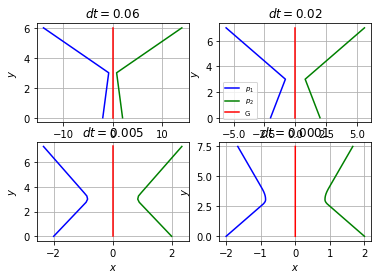

In [22]:
#####TEST DE COLLISION SYMETRIQUE##### 
#Permet de tester la valeur de dt dans un cas simple (pb de convergence): Verlet devrait permettre de prendre dt plus grand 


# paramètres pour CE test, attention a ne pas oublier de relancer In1 pour retrouver les valeurs globales 

# grains
R = 1
m = 1

# exterieur
L=20
e=2
y_min = -500
g = 0

# paramètres des contacts
Kc = 1e4 * m/R
restitution = 0.5
Kd = restitution**2*Kc
mu = 0
Kt = 0


Kc_p = 1e6/(2*R)
restitution_p = 0
Kd_p = restitution_p**2*Kc_p

mu_p = 1
Kt_p = 0


dt = 1e-4

paroi = False
gravite = False


if __name__=='__main__':
    

    grains = [grain(-2,-0,20,50), grain(2,0,-20,50)]
    plt.title(r'Décalage du centre de gravité des deux grains, selon la valeur de $dt$')
    liste = [0.6e-1, 2e-2, 5e-3, 1e-4]
    for k in range(4):
        dt = liste[k]
        plt.subplot(2,2,k+1)
        grains = [grain(-2,-0,20,50), grain(2,0,-20,50)]
        traj = trajectoires(grains, 0.15)
        plt.plot(traj[1][0],traj[2][0], 'b', label = r'$p_{1}$')
        plt.plot(traj[1][1],traj[2][1], 'g', label = r'$p_{2}$')
        xg = (traj[1][0] + traj[1][1])/2
        yg = (traj[2][0] + traj[2][1])/2
        plt.plot(xg, yg, 'r', label = 'G')
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        if k == 1:
            plt.legend(loc = 0, fontsize = 7)
        plt.grid()
        plt.title(r'$dt = ${}'.format(dt))
    plt.show()
    

Apres ce test on prend:

R = 1
m = 1


L=20
e=2
y_min = -500
g = 0

Kc = 1e4 * m/R
restitution = 0.5
Kd = restitution**2*Kc
mu = 0
Kt = 0


Kc_p = 1e6/(2*R)
restitution_p = 0
Kd_p = restitution_p**2*Kc_p

mu_p = 1
Kt_p = 0


dt = 1e-4


In [19]:
#####TEST DE FROTTEMENT AVEC LA PAROI##### 

# paramètres pour CE test, attention a ne pas oublier de relancer In1 pour retrouver les valeurs globales 




IndexError: index 1 is out of bounds for axis 0 with size 1